# Курсовой проект

Финальным аккордом нашей etl системы станет разложение источника в анкорную модель. Схематично это будет выглядеть так:

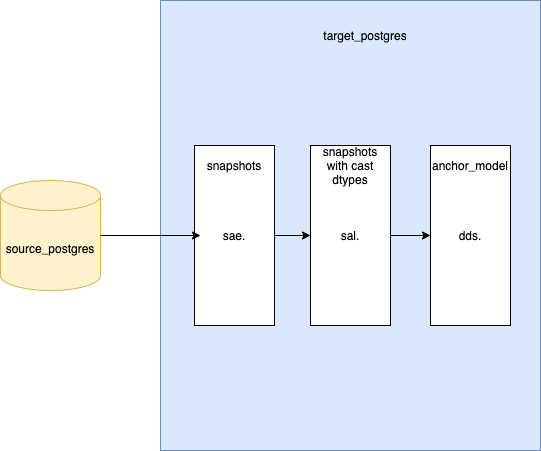

Чтобы реалезовать такую систему, нужно добавить операторы для перекладывания в sal и dds. Создадим файл layers.py:

In [ ]:
import logging
import time
import psycopg2
from airflow.utils.decorators import apply_defaults
from operators.utils import DataFlowBaseOperator


class SalOperator(DataFlowBaseOperator): #sae -> sal
    defaults = {
        'target_schema': 'sal',
        'source_schema': 'sae',
    }
    
    @apply_defaults
    def __init__(self, config, pg_conn_str, query=None, *args, **kwargs):
        super(SalOperator, self).__init__(
            config=config,
            pg_conn_str=pg_conn_str,
            *args,
            **kwargs
        )
        self.pg_conn_str = pg_conn_str
        self.config = dict(self.defaults, **config)
        self.query = query

    def execute(self, context):
        with psycopg2.connect(self.pg_conn_str) as conn, conn.cursor() as cursor:
            self.config.update(
                job_id=context['task_instance'].job_id,
                dt=context["task_instance"].execution_date,
            )
            ids = self.get_launch_ids(self.config)
            self.log.info("Ids found: {}".format(ids))

            for launch_id in ids:
                start = time.time()
                self.config.update(
                    launch_id=launch_id,
                )

                cols_sql = """
                select column_name
                     , data_type
                  from information_schema.columns
                 where table_schema = '{target_schema}'
                   and table_name = '{target_table}'
                   and column_name not in ('launch_id', 'effective_dttm');
                """.format(**self.config)

                cursor.execute(cols_sql)
                cols_list = list(cursor.fetchall())
                cols_dtypes = ",\n".join(('{}::{}'.format(col[0], col[1]) for col in cols_list))
                cols = ",\n".join(col[0] for col in cols_list)
                if query:
                    transfer_sql = """
                    with x as ({query})
                    insert into {target_schema}.{target_table} (launch_id, {cols})
                    select {job_id}::int as launch_id,\n{cols_dtypes}\n from x
                    """.format(query=self.query, cols_dtypes=cols_dtypes, cols=cols, **self.config)
                else:
                    transfer_sql = """
                    insert into {target_schema}.{target_table} (launch_id, {cols})
                    select {job_id}::int as launch_id,\n{cols_dtypes}\n from {source_schema}.{source_table}
                    """.format(cols_dtypes=cols_dtypes, cols=cols, **self.config)
                self.log.info('Executing query: {}'.format(transfer_sql))
                cursor.execute(transfer_sql)

                self.config.update(
                    source_schema=source_schema,
                    duration=datetime.timedelta(seconds=time.time() - start),
                    row_count=cursor.rowcount
                )
                self.log.info('Inserted rows: {row_count}'.format(**self.config))
                self.write_etl_log(self.config)


class DdsHOperator(DataFlowBaseOperator): #sal -> dds for hubs
    defaults = {
        'target_schema': 'dds',
        'source_schema': 'sal',
    }

    @apply_defaults
    def __init__(self, config, pg_conn_str, *args, **kwargs):
        self.config = dict(
            self.defaults,
            target_table='h_{hub_name}'.format(**config),
            hub_bk='{hub_name}_bk'.format(**config),
            **config
        )
        super(DdsHOperator, self).__init__(
            config=config,
            pg_conn_str=pg_conn_str,
            *args,
            **kwargs
        )
        self.pg_conn_str = pg_conn_str

    def execute(self, context):
        with psycopg2.connect(self.pg_conn_str) as conn, conn.cursor() as cursor:

            self.config.update(
                job_id=context['task_instance'].job_id,
                dt=context["task_instance"].execution_date,
            )
            ids = self.get_launch_ids(self.config)
            self.log.info("Ids found: {}".format(ids))

            for launch_id in ids:
                start = time.time()

                self.config.update(
                    launch_id=launch_id
                )

                insert_sql = '''
                with x as (
                   select {bk_column}
                        , {job_id}
                     from {source_schema}.{source_table} s
                    where {bk_column} is not null
                      and s.launch_id = {launch_id}
                    group by 1
                )
                insert into {target_schema}.{target_table} ({hub_bk}, launch_id)
                select * from x
                    on conflict ({bk_column})
                    do nothing;
                '''.format(**self.config)

                self.log.info('Executing query: {}'.format(insert_sql))
                cursor.execute(insert_sql)

                self.config.update(
                    row_count=cursor.rowcount
                )
                self.log.info('Row count: {row_count}'.format(**self.config))
                self.config.update(
                    duration=datetime.timedelta(seconds=time.time() - start)
                )
                self.write_etl_log(self.config)


class DdsLOperator(DataFlowBaseOperator): #sal -> dds for links
    defaults = {
        'target_schema': 'dds',
        'source_schema': 'sal',
    }

    @apply_defaults
    def __init__(self, config, pg_conn_str, *args, **kwargs):
        super(DdsLOperator, self).__init__(
            config=config,
            pg_conn_str=pg_conn_str,
            *args,
            **kwargs
        )
        self.config = dict(
            self.defaults,
            target_table='l_{l_hub_name}_{r_hub_name}'.format(**config),
            **config
        )
        self.pg_conn_str = pg_conn_str

    def execute(self, context):
        with psycopg2.connect(self.pg_conn_str) as conn, conn.cursor() as cursor:
            self.config.update(
                job_id=context['task_instance'].job_id,
                dt=context["task_instance"].execution_date,
            )
            ids = self.get_launch_ids(self.config)
            self.log.info("Ids found: {}".format(ids))

            for launch_id in ids:
                start = time.time()
                self.config.update(
                    launch_id=launch_id,
                )

                insert_sql = '''
                with x as (
                    select distinct
                           {l_hub_name}_id
                         , {r_hub_name}_id
                      from {source_schema}.{source_table} s
                      join dds.h_{l_hub_name} l
                      on s.{l_bk_column} = l.{l_hub_name}_id
                      join dds.h_{r_hub_name} r
                      on s.h_{r_bk_column} = r.{r_hub_name}_id
                      where s.launch_id = {launch_id}
                )
                insert into {target_schema}.{target_table} ({l_hub_name}_id, {l_hub_name}_id, launch_id)
                select {l_hub_name}_id
                     , {r_hub_name}_id
                     , {job_id}
                  from x;
                '''.format(**self.config)

                self.log.info('Executing query: {}'.format(insert_sql))
                cursor.execute(insert_sql)
                self.config.update(
                    row_count=cursor.rowcount,
                    duration=datetime.timedelta(seconds=time.time() - start)
                )
                self.log.info('Row count: {row_count}'.format(**self.config))
                self.write_etl_log(self.config)


class DdsSOperator(DataFlowBaseOperator): #sal -> dds for sattelites
    defaults = {
        'target_schema': 'dds',
        'source_schema': 'sal',
    }

    @apply_defaults
    def __init__(self, config, pg_conn_str, *args, **kwargs):
        super(DdsSOperator, self).__init__(
            config=config,
            pg_conn_str=pg_conn_str,
            *args,
            **kwargs
        )
        self.config = dict(
            self.defaults,
            target_table='s_{hub_name}_{satellite_name}'.format(**config),
            **config
        )
        self.pg_conn_str = pg_conn_str

    def execute(self, context):
        with psycopg2.connect(self.pg_conn_str) as conn, conn.cursor() as cursor:
            self.config.update(
                job_id=context['task_instance'].job_id,
                dt=context["task_instance"].execution_date,
            )
            ids = self.get_launch_ids(self.config)
            self.log.info("Ids found: {}".format(ids))

            for launch_id in ids:
                start = time.time()
                self.config.update(
                    launch_id=launch_id,
                )

                insert_sql = '''
                with x as (
                    select distinct
                           {hub_name}_id
                         , {satellite_name}
                      from {source_schema}.{source_table} s
                      join dds.h_{hub_name} h
                      on s.{bk_column} = h.{hub_name}_id
                      where s.launch_id = {launch_id}
                )
                insert into {target_schema}.{target_table} ({hub_name}_id, {satellite_name}, launch_id)
                select {hub_name}_id
                     , {satellite_name}
                     , {job_id}
                  from x;
                '''.format(**self.config)

                self.log.info('Executing query: {}'.format(insert_sql))
                cursor.execute(insert_sql)
                self.config.update(
                    row_count=cursor.rowcount,
                    duration=datetime.timedelta(seconds=time.time() - start)
                )
                self.log.info('Row count: {row_count}'.format(**self.config))
                self.write_etl_log(self.config)


Добавим метод get_launch_ids в DataFlowBaseOperator, чтобы иметь возможность грузить конкретный батч данных:

In [ ]:
    def get_launch_ids(self, config):
        with psycopg2.connect(self.pg_meta_conn_str) as conn, conn.cursor() as cursor:
            query = '''
            select array_agg(distinct target_launch_id order by target_launch_id)::int[]
                from log
                where target_launch_id not in (
                select source_launch_id
                    from etl.log
                    where target_table = '{target_table}'
                    and target_schema = '{target_schema}'
                    and source_launch_id is not null
                    )
                and target_table = '{source_table}'
                and target_schema = '{source_schema}'
            '''
            cursor = conn.cursor()
            logging.info('Executing metadata query: {}'.format(query.format(**config)))
            cursor.execute(query.format(**config))
            ids = cursor.fetchone()[0]
            logging.info('Launch_ids: {}'.format(ids))
        return tuple(ids.strip('{}').split(',')) if ids else ()


Также нам потребуется конфигурационный файл, в котором будет информация о источниках и сущностях. Создадим его shema.yaml:

shema.yaml глобально делится на две части: 
    
    • groups - содержит информацию о хабах, линках и саттелитах
    • sources - содержит информацию о колонках таблиц источников и к какой сущности они относятся

Также с помощью это файла можно настроить через git генерацию таблиц в dds слое.

Хабы будут иметь вид:

Таким образом мы поддерживаем уникальность сурогатного и бизнес ключа.

Линки будут иметь вид:

Сателлиты будут иметь вид:

Создадим даг для нашего пайплайна:

In [ ]:
from airflow import DAG
from operators.postgres import DataTransferPostgres
from operators.layers import SalOperator, DdsSOperator, DdsHOperator, DdsLOperator
from datetime import datetime
import yaml
import os


with open(os.path.join(os.path.dirname(__file__), 'schema.yaml'), encoding='utf-8') as f:
    YAML_DATA = yaml.safe_load(f)


DEFAULT_ARGS = {
    "owner": "airflow",
    "start_date": datetime(2021, 1, 25),
    "retries": 1,
    "email_on_failure": False,
    "email_on_retry": False,
    "depends_on_past": True,
}

SAE_QUERY = 'select * from {table}'


with DAG(
    dag_id="pg-data-flow6",
    default_args=DEFAULT_ARGS,
    schedule_interval="@daily",
    max_active_runs=1,
    tags=['data-flow'],
) as dag1:
    sae = {
        table: DataTransferPostgres(
            config=dict(
                table='sae.{table}'.format(table=table)
            ),
            query=SAE_QUERY.format(table=table),
            task_id='sae_{table}'.format(table=table),
            source_pg_conn_str="host='localhost' port=54320 dbname='tpch' user='postgres' password='postgres'",
            pg_conn_str="host='localhost' port=5433 dbname='my_database2' user='admin' password='postgres'",
            pg_meta_conn_str="host='localhost' port=5433 dbname='my_database2' user='admin' password='postgres'",
        )
        for table in YAML_DATA['sources']['tables'].keys()
    }

    sal = {
        table: SalOperator(
            config=dict(
                target_table=table,
                source_table=table,
            ),
            task_id='sal_{table}'.format(table=table),
            pg_conn_str="host='localhost' port=5433 dbname='my_database2' user='admin' password='postgres'",
            pg_meta_conn_str="host='localhost' port=5433 dbname='my_database2' user='admin' password='postgres'",
        )
        for table in YAML_DATA['sources']['tables'].keys()
    }

    for target_table, task in sal.items():
        sae[target_table] >> task
    
    hubs = {
        hub_name: {
            table: DdsHOperator(
                task_id='dds.h_{hub_name}'.format(hub_name=hub_name),
                config={
                    'hub_name': hub_name,
                    'source_table': table,
                    'bk_column': bk_column
                },
                pg_conn_str="host='localhost' port=5433 dbname='my_database2' user='admin' password='postgres'",
                pg_meta_conn_str="host='localhost' port=5433 dbname='my_database2' user='admin' password='postgres'",
            )
            for table, cols in YAML_DATA['sources']['tables'].items()
            for col in cols['columns']
            for bk_column, inf in col.items()
            if inf.get('bk_for') == hub_name
        }
        for hub_name in YAML_DATA['groups']['hubs'].keys()
    }

    for hub, info in hubs.items():
        for source_table, task in info.items():
            sal[source_table] >> task

    sattelites = {
        (hub_name, satellite_name): {
            table_name: DdsSOperator(
                task_id='dds.s_{hub_name}_{satellite_name}'.format(hub_name=hub_name, satellite_name=satellite_name),
                pg_conn_str="host='localhost' port=5433 dbname='my_database2' user='admin' password='postgres'",
                pg_meta_conn_str="host='localhost' port=5433 dbname='my_database2' user='admin' password='postgres'",
                config=dict(
                    hub_name=hub_name,
                    bk_column=bk_column,
                    satellite_name=satellite_name,
                )
            )
            for table_name, cols in YAML_DATA['sources']['tables'].items()
            for col in cols['columns']
            for bk_column, inf in col.items()
            if inf.get('bk_for') == hub_name
        }
        for hub_name, info in YAML_DATA['groups']['hubs'].items()
        for satellite_name in info['satellites'].keys()
    }

    for (hub, sat), info in sattelites.items():
        for source_table, task in info.items():
            hubs[hub][source_table] >> task

    links = {
        (l_hub_name, r_hub_name): {
            table_name: DdsLOperator(
                task_id='dds.l_{l_hub_name}_{r_hub_name}'.format(l_hub_name=l_hub_name, r_hub_name=r_hub_name),
                pg_conn_str="host='localhost' port=5433 dbname='my_database2' user='admin' password='postgres'",
                pg_meta_conn_str="host='localhost' port=5433 dbname='my_database2' user='admin' password='postgres'",
                config=dict(
                    l_hub_name=l_hub_name,
                    r_hub_name=r_hub_name,
                    l_bk_column=l_bk_column,
                    r_bk_column=r_bk_column,
                    source_table=table_name,
                )
            )
            for table_name, cols in YAML_DATA['sources']['tables'].items()
            for l_col in cols['columns']
            for l_bk_column, inf in l_col.items()
            if inf.get('bk_for') == l_hub_name
            for r_col in cols['columns']
            for r_bk_column, inf in r_col.items()
            if inf.get('bk_for') == r_hub_name
        }
        for l_hub_name, info in YAML_DATA['groups']['hubs'].items()
        for r_hub_name in info['links'].keys()
    }

    for (l_hub, r_hub), info in links.items():
        for source_table, task in info.items():
            hubs[l_hub][source_table] >> task
            hubs[r_hub][source_table] >> task

Демонстрация построения зависимостей в даге:

In [4]:
import yaml
import os

with open('schema.yaml', encoding='utf-8') as f:
    YAML_DATA = yaml.safe_load(f)


links = {
    (l_hub_name, r_hub_name): {
        table_name: 'dds.l_{l_hub_name}_{r_hub_name}'.format(l_hub_name=l_hub_name, r_hub_name=r_hub_name)
        for table_name, cols in YAML_DATA['sources']['tables'].items()
        for l_col in cols['columns']
        for l_bk_column, inf in l_col.items()
        if inf.get('bk_for') == l_hub_name
        for r_col in cols['columns']
        for r_bk_column, inf in r_col.items()
        if inf.get('bk_for') == r_hub_name
    }
    for l_hub_name, info in YAML_DATA['groups']['hubs'].items()
    for r_hub_name in info['links'].keys()
}

hubs = {
    hub_name: {
        table: 'dds.h_{hub_name}'.format(hub_name=hub_name)
        for table, cols in YAML_DATA['sources']['tables'].items()
        for col in cols['columns']
        for bk_column, inf in col.items()
        if inf.get('bk_for') == hub_name
    }
    for hub_name in YAML_DATA['groups']['hubs'].keys()
}

sattelites = {
    (hub_name, satellite_name): {
        table_name: 'dds.s_{hub_name}_{satellite_name}'.format(hub_name=hub_name, satellite_name=satellite_name)
        for table_name, cols in YAML_DATA['sources']['tables'].items()
        for col in cols['columns']
        for bk_column, inf in col.items()
        if inf.get('bk_for') == hub_name
    }
    for hub_name, info in YAML_DATA['groups']['hubs'].items()
    for satellite_name in info['satellites'].keys()
}

print('hub -> links:')
for (l_hub, r_hub), info in links.items():
    for source_table, task in info.items():
        print(hubs[l_hub][source_table] + '--' + task)
        print(hubs[r_hub][source_table] + '--' + task)
        print('========')

hub -> links:
dds.h_supplier--dds.l_supplier_nation
dds.h_nation--dds.l_supplier_nation
dds.h_partsupp--dds.l_partsupp_supplier
dds.h_supplier--dds.l_partsupp_supplier
dds.h_partsupp--dds.l_partsupp_part
dds.h_part--dds.l_partsupp_part
dds.h_lineitem--dds.l_lineitem_orders
dds.h_orders--dds.l_lineitem_orders
dds.h_orders--dds.l_orders_customer
dds.h_customer--dds.l_orders_customer
dds.h_customer--dds.l_customer_nation
dds.h_nation--dds.l_customer_nation
dds.h_nation--dds.l_nation_region
dds.h_region--dds.l_nation_region


In [5]:
print('hub -> satellites:')
for (hub, sat), info in sattelites.items():
    for source_table, task in info.items():
        print(hubs[hub][source_table] + '--' + task)

hub -> satellites:
dds.h_part--dds.s_part_name
dds.h_part--dds.s_part_name
dds.h_part--dds.s_part_name
dds.h_part--dds.s_part_mfgr
dds.h_part--dds.s_part_mfgr
dds.h_part--dds.s_part_mfgr
dds.h_part--dds.s_part_brand
dds.h_part--dds.s_part_brand
dds.h_part--dds.s_part_brand
dds.h_part--dds.s_part_type
dds.h_part--dds.s_part_type
dds.h_part--dds.s_part_type
dds.h_part--dds.s_part_size
dds.h_part--dds.s_part_size
dds.h_part--dds.s_part_size
dds.h_part--dds.s_part_container
dds.h_part--dds.s_part_container
dds.h_part--dds.s_part_container
dds.h_part--dds.s_part_retailprice
dds.h_part--dds.s_part_retailprice
dds.h_part--dds.s_part_retailprice
dds.h_part--dds.s_part_comment
dds.h_part--dds.s_part_comment
dds.h_part--dds.s_part_comment
dds.h_supplier--dds.s_supplier_name
dds.h_supplier--dds.s_supplier_name
dds.h_supplier--dds.s_supplier_name
dds.h_supplier--dds.s_supplier_addres
dds.h_supplier--dds.s_supplier_addres
dds.h_supplier--dds.s_supplier_addres
dds.h_supplier--dds.s_supplier_phone
dd

Подведем итоги:
    
    • спроектировали схему хранилища
    • реализовали операторы для разложения данных по слоям
    • определили вид конфигурационного файла, для описания модели данных
    • написали даг с полным etl пайплайном 

## Домашнее задание

Реализовать etl систему для загрузки data vault